In [1]:
import cv2
import math
import mediapipe as mp

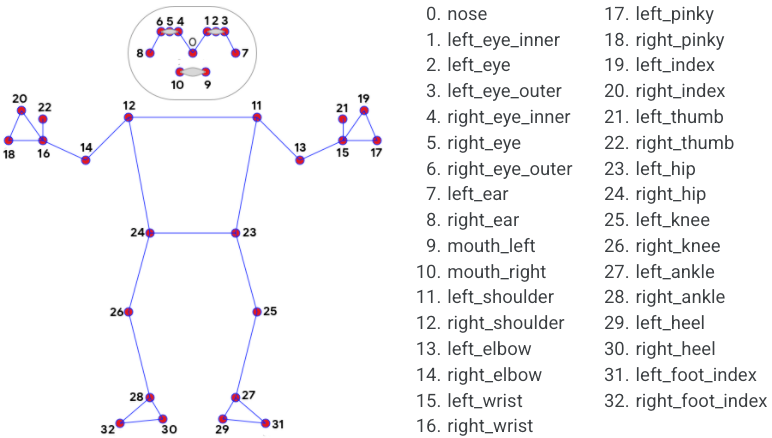

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [16]:
def angle_to_vertical(ax, ay, bx, by):
    """
    Угол между отрезком и вертикально. В MediaPipe y растёт ВНИЗ, поэтому "вверх" — это -y
    """
    dx = bx - ax
    dy = by - ay
    
    # Меняем x и y местами, считая, как будто ось Х вертикальная.
    angle_rad = math.atan2(dx, -dy)
    angle_deg = abs(math.degrees(angle_rad))
    return angle_deg

In [12]:
def get_point(landmarks, idx):
    lm = landmarks[idx]
    return lm.x, lm.y, lm.visibility

In [13]:
def pick_side_or_center(landmarks):
    """
    Пытаемся взять центр плеч и бёдер.
    Если видно оба плеча/бедра — берём центр.
    Иначе берём сторону, где видимость выше.
    """
    ls_x, ls_y, ls_vis = get_point(landmarks, mp_pose.PoseLandmark.LEFT_SHOULDER)
    rs_x, rs_y, rs_vis = get_point(landmarks, mp_pose.PoseLandmark.RIGHT_SHOULDER)
    lh_x, lh_y, lh_vis = get_point(landmarks, mp_pose.PoseLandmark.LEFT_HIP)
    rh_x, rh_y, rh_vis = get_point(landmarks, mp_pose.PoseLandmark.RIGHT_HIP)

    if ls_vis > 0.6 and rs_vis > 0.65:
        shoulders_x = (ls_x + rs_x) / 2
        shoulders_y = (ls_y + rs_y) / 2
    else:
        # Берём сторону с лучшей видимостью
        if ls_vis >= rs_vis:
            shoulders_x, shoulders_y = ls_x, ls_y
        else:
            shoulders_x, shoulders_y = rs_x, rs_y

    if lh_vis > 0.6 and rh_vis > 0.6:
        hips_x = (lh_x + rh_x) / 2
        hips_y = (lh_y + rh_y) / 2
    else:
        if lh_vis >= rh_vis:
            hips_x, hips_y = lh_x, lh_y
        else:
            hips_x, hips_y = rh_x, rh_y

    return shoulders_x, shoulders_y, hips_x, hips_y

In [6]:
def estimate_neck_angle(landmarks):
    """
    Угол шеи (ухо–плечо) относительно вертикали.
    Берём ту сторону, где видимость лучше.
    """
    ls_x, ls_y, ls_vis = get_point(landmarks, mp_pose.PoseLandmark.LEFT_SHOULDER)
    rs_x, rs_y, rs_vis = get_point(landmarks, mp_pose.PoseLandmark.RIGHT_SHOULDER)
    le_x, le_y, le_vis = get_point(landmarks, mp_pose.PoseLandmark.LEFT_EAR)
    re_x, re_y, re_vis = get_point(landmarks, mp_pose.PoseLandmark.RIGHT_EAR)

    angle_deg = None

    # Пробуем левую сторону
    if ls_vis > 0.5 and le_vis > 0.5:
        angle_deg = angle_to_vertical(ls_x, ls_y, le_x, le_y)
    # Если левая не зашла, пробуем правую
    elif rs_vis > 0.5 and re_vis > 0.5:
        angle_deg = angle_to_vertical(rs_x, rs_y, re_x, re_y)

    return angle_deg

In [1]:
cap = cv2.VideoCapture(0)

with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        height, width, _ = frame.shape

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        results = pose.process(rgb)
        rgb.flags.writeable = True

        posture_text = "There is no human"
        color = (153, 255, 51)
        torso_angle_deg = None
        neck_angle_deg = None

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Высчитываем угол туловища
            shoulders_x, shoulders_y, hips_x, hips_y = pick_side_or_center(landmarks)
            torso_angle_deg = angle_to_vertical(hips_x, hips_y, shoulders_x, shoulders_y)

            # Угол шеи
            neck_angle_deg = estimate_neck_angle(landmarks)

            torso_ok = torso_angle_deg is not None and torso_angle_deg < 10
            neck_ok = neck_angle_deg is None or neck_angle_deg < 15

            if torso_ok and neck_ok:
                posture_text = "Posture: OK"
            else:
                posture_text = "Straighten your back!!"
                color = (0, 0, 255)

            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS
            )

             # Рисуем линию туловища на экране
            sx, sy = int(shoulders_x * width), int(shoulders_y * height)
            hx, hy = int(hips_x * width), int(hips_y * height)
            cv2.line(frame, (hx, hy), (sx, sy), color, 3)

            # Подпишем углы (для дебага, чтобы понимать пороги)
            y0 = 30
            cv2.putText(frame, f"Torso angle: {torso_angle_deg:.1f} deg",
                        (10, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            y0 += 25
            if neck_angle_deg is not None:
                cv2.putText(frame, f"Neck angle: {neck_angle_deg:.1f} deg",
                            (10, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            else:
                cv2.putText(frame, "Neck angle: N/A",
                            (10, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Общий статус
        cv2.putText(frame, posture_text,
                    (10, height - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        cv2.imshow("Posture", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined